# Stochastic model in Weichsel and Schwarz, PNAS, 2010

## Setup

- The network grows in the horizontal direction, and the vertical boundary conditions are periodic.
- Polymerization occurs every where behind the leading edge at a constant rate of 1 nm/ms.
- Force on the network is simulated by fixing a number of filaments to the leading edge. These filaments do not elongate, branch or get cap.
- Branching and capping are stochastic events that occur only $2\delta$ behind the position of the last fixed barbed end; $\delta$ is the width of an actin monomer.
- The Monte Carlo step compares the time resolution $dt$ of the simulation and a number randomly sampled from a distribution of wait times defined by a given Poisson process.
- Branching occurs at a rate that is independent from the number of filaments. Since the simulation iterates over each filament, the branching rate is divided by the number of filaments.
- Capping occurs at a rate that is first-order with respect to the number of filaments.
- The network moves at a rate that is an input variable in the simulation, and the architecture of the network is determined essentially by the number and orientation of active filaments that can keep up with the leading edge.

## Implementation

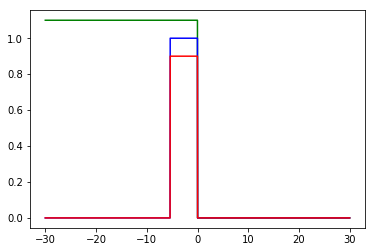

In [1]:
from weichselSchwarz import *
from numpy import pi, sin, cos, arccos, sqrt, median, convolve, diagonal, corrcoef, argmax, insert, cumsum, std, unique, savetxt, vstack, nanstd, nanmean, hstack, NaN, zeros, correlate, ones
from matplotlib.pyplot import *
from matplotlib.cm import *
%matplotlib inline

# Parameter values for the simulation.
N = 200 # initial number of filaments
dN = 2.7 # length of a monomer, in nm
filRange = 1000.0 # width of the leading edge, in nm
T = 20.0 # simulation run time, in s
dt = 0.0027 # duration of time interval, in s
ds = 2.0 # frame rate
dw = 2 * dN # width of branching zone, in nm

# Rate functions.
# Elongation
lambdaRate = dN / dt
def rLambda(x, y, t):
    return lambdaRate * heavisideTheta(y)

# Branching
#betaRate = 20.0
betaRate = 7410.0
def rBeta(x, y, t):
    return betaRate * heavisidePi(y, dw)

# Capping
#kappaRate = 0.05
kappaRate = 18.5 # per filament
def rKappa(x, y, t):
    return kappaRate * heavisidePi(y, dw)

# Plot rate functions.
a = arange(-30, 30, 0.01)
plot(a, [1.1 * rLambda(0, y, 0) / lambdaRate for y in a], 'g')
plot(a, [rBeta(0, y, 0) / betaRate for y in a], 'b')
plot(a, [0.9 * rKappa(0, y, 0) / kappaRate for y in a], 'r')

In [2]:
# Sample from uniform distribution given N filaments.
thetaDist = uniform(-pi / 2.0, pi / 2.0, size = N)
xDist = uniform(low = 0.0, high = filRange, size = N)
yDist = uniform(low = -dw, high = 0.0, size = N)

xInit = array([[x, y] for x, y in zip(xDist, yDist)])
dxInit = array([[dN * sin(theta), dN * cos(theta)] for theta in thetaDist])

# Initialize object.
n = network(rLambda, rBeta, rKappa, xSeed = xInit, dxSeed = dxInit, branchSigma = 5.0 * pi / 180, nFront = 50, forceDirection= True, recordHistory = True)
n.exportData(dt, ds, n.tElapsed + T, Fext = 1.0e-1)

/home/jiongyi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 993.7448029291952)

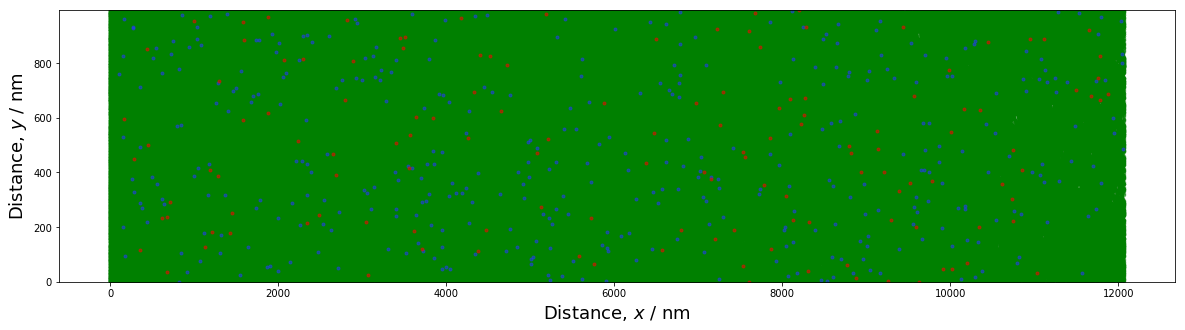

In [3]:
# Plot network.
xFil = n.getPositions(n.Monomers)
xBranch = n.getPositions(n.Branches)
xCap = n.getPositions(n.Caps)
figure(figsize=(20,5))
plot(xFil.T[1], xFil.T[0], 'g', marker = ".", linewidth = 0, ms = 5, alpha = 0.2)
if len(xBranch) != 0:
    plot(xBranch.T[1], xBranch.T[0], '#2737ff', marker = ".", linewidth = 0, ms = 6, alpha = 0.5)
if len(xCap) != 0:
    plot(xCap.T[1], xCap.T[0], '#ff0000', marker = ".", linewidth = 0, ms = 6, alpha = 0.5)
xlabel(r"Distance, $x$ / nm", fontsize = 18)
ylabel(r"Distance, $y$ / nm", fontsize = 18)
ylim(0, n.xBoundary)

Text(0,0.5,'Growth rate (nm/s)')

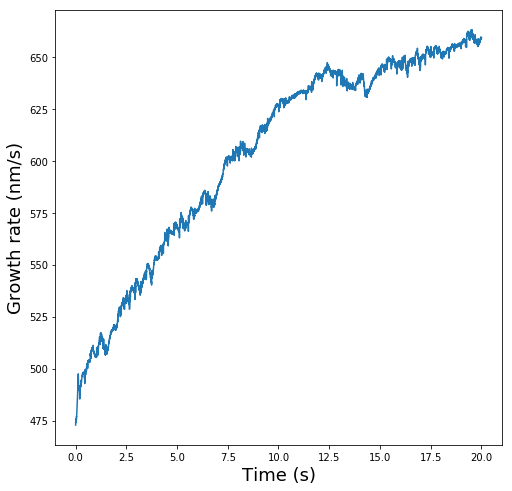

In [4]:
from numpy import gradient
from scipy.signal import savgol_filter
t = linspace(0.0, n.tElapsed, num = len(n.nFilaments))
figure(figsize = (8, 8))
plot(t, savgol_filter(gradient(n.yNet, t), 101, 3, mode = 'mirror'))
xlabel(r"Time (s)", fontsize = 18)
ylabel(r"Growth rate (nm/s)", fontsize = 18)